# Prerequesites
Installing dependencies, importing libraries and dataset.

In [ ]:
!pip cache purge
!pip install transformers datasets bertviz umap-learn torch transformers[torch] --no-cache-dir

Files removed: 8


In [2]:
import pandas as pd
from datasets import load_dataset

emotion = load_dataset('emotion')
emotion.set_format("pandas")
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
train_df = emotion['train'][:]
train_df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


## Retrieving label names

In [4]:
classes = emotion['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [5]:
train_df['label_name'] = train_df['label'].apply(lambda x: classes[x])
train_df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# Exploratory Analysis

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

label_name
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


Text(0.5, 1.0, 'Frequency of Classes')

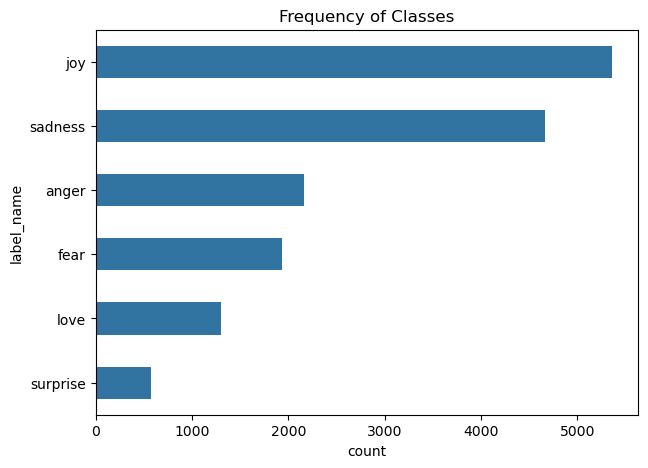

In [7]:
print(train_df['label_name'].value_counts())

plt.figure(figsize=(7,5))
sns.countplot(data=train_df, y="label_name", order=train_df['label_name'].value_counts(ascending=False).index, width=0.5)
plt.title("Frequency of Classes")

In [8]:
train_df['words_per_tweet'] = train_df['text'].str.split().apply(len)
train_df['words_per_tweet'].head()

0     4
1    21
2    10
3    18
4     4
Name: words_per_tweet, dtype: int64

Text(0.5, 1.0, 'Classes boxplot')

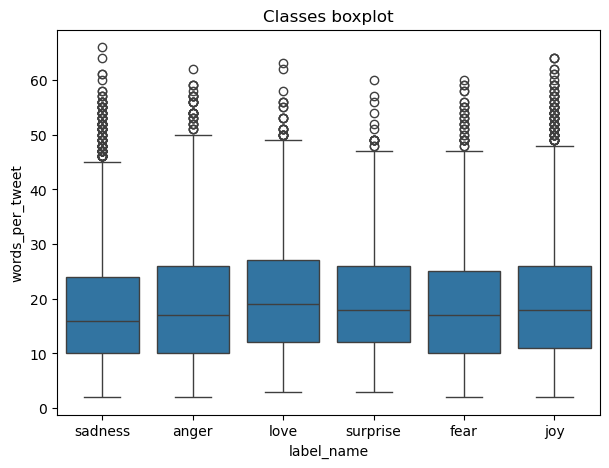

In [9]:
plt.figure(figsize=(7,5))
sns.boxplot(data=train_df, x='label_name', y='words_per_tweet')
plt.title('Classes boxplot')

# Tokenization
DistilBERT has token limit of 512 tokens. We saw that there is no tweet with words above 500 words.

In [10]:
import transformers
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [11]:
text = "This is an example of tokenization. Look, how awesome it is!"
encoded_text = tokenizer(text)
tokens_text = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
tokens_text

['[CLS]',
 'this',
 'is',
 'an',
 'example',
 'of',
 'token',
 '##ization',
 '.',
 'look',
 ',',
 'how',
 'awesome',
 'it',
 'is',
 '!',
 '[SEP]']

In [12]:
emotion.reset_format()

In [13]:
def tokenize(batch):
    data = tokenizer(batch['text'], padding=True, truncation=True)
    return data

print(tokenize(emotion['train'][:5]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2572, 2412, 3110, 16839, 9080, 12863, 2055, 1996, 13788, 1045, 2097, 2113, 2008, 2009, 2003, 2145, 2006, 1996, 3200, 102, 0], [101, 1045, 2572, 3110, 24665, 7140, 11714, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}


In [14]:
emotion_encoded = emotion.map(tokenize, batched=True, batch_size=None)

In [15]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

# Model Building

In [16]:
inputs = tokenizer(text, return_tensors='pt')
inputs

{'input_ids': tensor([[  101,  2023,  2003,  2019,  2742,  1997, 19204,  3989,  1012,  2298,
          1010,  2129, 12476,  2009,  2003,   999,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [17]:
from transformers import AutoModel
import torch

model = AutoModel.from_pretrained(model_ckpt)

In [18]:
with torch.no_grad():
    outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
print(last_hidden_states)

tensor([[[-0.1173, -0.2700, -0.1406,  ..., -0.1401,  0.1791,  0.6232],
         [-0.5689, -0.4017, -0.2870,  ..., -0.1935,  0.5518,  0.4693],
         [-0.5559, -0.2654,  0.0122,  ..., -0.1280, -0.0089,  1.0860],
         ...,
         [-0.1224, -0.4172,  0.0377,  ...,  0.0205,  0.1158,  0.8462],
         [ 0.1059, -0.2754, -0.2046,  ...,  0.0810,  0.0664,  0.0611],
         [ 0.5298,  0.1208, -0.2337,  ...,  0.1731, -0.6531,  0.0548]]])


# Fine Tuning Transformer model

In [19]:
from transformers import AutoModelForSequenceClassification

num_labels = len(classes)
device = torch.device("cpu")

model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=num_labels
).to(device)

print(f'\ndevice: {device}\n')
print(model)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



device: cpu

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, i

In [23]:
from transformers import TrainingArguments, Trainer

batch_size = 64
model_name = "models/distilbert-finetuned-emotion"

training_args = TrainingArguments(
    output_dir = model_name,
    num_train_epochs = 2,
    learning_rate = 0.0001,
    per_device_train_batch_size = batch_size,
    per_device_eval_batch_size = batch_size,
    weight_decay = 0.01,
    eval_strategy = 'epoch',
    disable_tqdm=False
)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
def get_metrics(pred):
    labels = pred.label_ids
    preds = pred.prediction.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy":acc, "f1_score":f1}

In [ ]:
from transformers import Trainer

trainer = Trainer(
    args=training_args,
    model=model,
    compute_metrics=get_metrics,
    train_dataset=emotion_encoded['train'],
    eval_dataset=emotion_encoded['validation'],
    processing_class=tokenizer
)

In [ ]:
trainer.train()